使用决策树预测毒蘑菇

In [11]:
# 导入包
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
# 导入warnings模块，并设置忽略警告信息的过滤器
import warnings
warnings.filterwarnings('ignore')
# 设置字段名
head_name = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment',
            'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-surface-above-ring',
            'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring',
            'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color',
            'population', 'habitat',"label"]

# 从CSV文件中加载训练数据
train_df = pd.read_csv('C:\\Users\\DELL\\Desktop\\机器学习\\mushroom_for_decisionTree_train.csv', names = head_name)

# 从CSV文件中加载测试数据
test_df = pd.read_csv('C:\\Users\\DELL\\Desktop\\机器学习\\mushroom_for_decisionTree_test.csv', names = head_name)
encoder = OneHotEncoder()
# 获取特征名
feature_cols = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment',
            'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-surface-above-ring',
            'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring',
            'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color',
            'population', 'habitat']
# 独热编码
encoder.fit(train_df[feature_cols])

# 转换训练数据和测试数据
X_train = encoder.transform(train_df[feature_cols])
X_test = encoder.transform(test_df[feature_cols])

y_train = train_df["label"]
y_test = test_df["label"]



In [12]:
train_df.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,label
count,5686,5686,5686,5686,5686,5686,5686,5686,5686,5686,...,5686,5686,5686,5686,5686,5686,5686,5686,5686,5686
unique,6,4,10,2,9,2,2,2,12,2,...,9,9,1,4,3,5,9,6,7,2
top,x,y,n,f,n,f,c,b,b,t,...,w,w,p,w,o,p,w,v,d,e
freq,2571,2250,1600,3334,2486,5544,4757,3916,1222,3245,...,3145,3072,5686,5550,5239,2776,1692,2837,2182,2945


In [13]:
# 从sklearn中导入决策树
from sklearn.tree import DecisionTreeClassifier

# 创建一个决策树对象
dt_classifier = DecisionTreeClassifier(random_state=42)

# 训练决策树
dt_classifier.fit(X_train, Y_train)

# 用训练好的决策树预测测试数据集
y_pred_test = dt_classifier.predict(X_test)

# 计算测试数据集的准确率
accuracy_test = dt_classifier.score(X_test, Y_test)
print("Test accuracy:", accuracy_test)

Test accuracy: 1.0


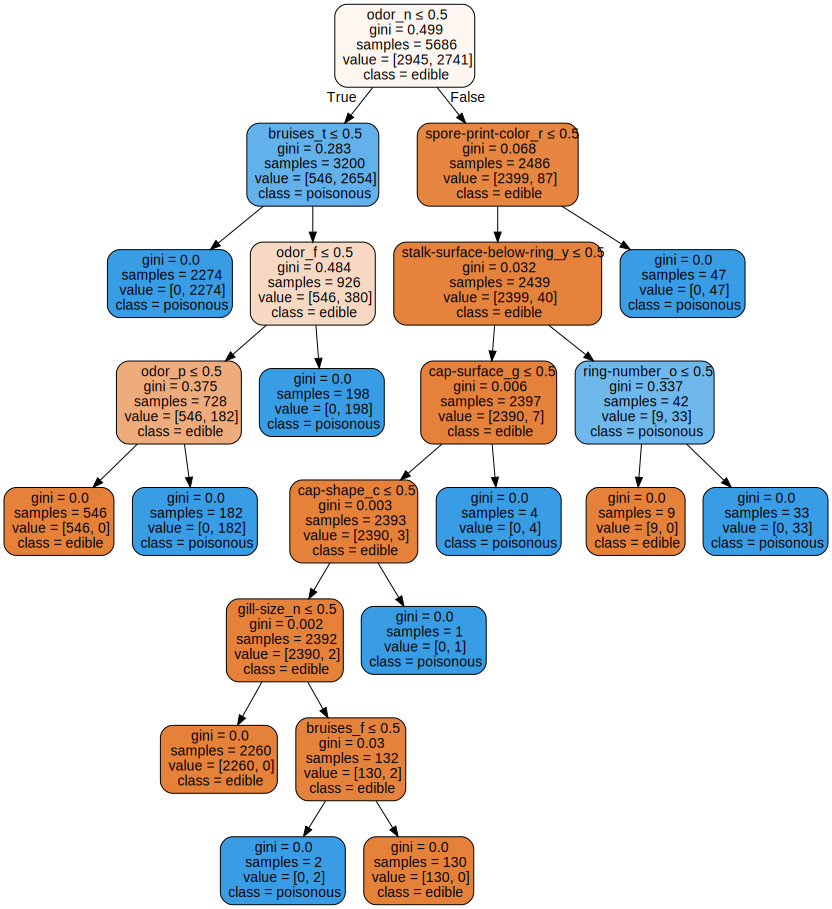

In [14]:
from sklearn.tree import export_graphviz
import graphviz

# 在独热编码后获取特征名称
feature_names = encoder.get_feature_names(feature_cols)

# 将决策树导出
dot_data = export_graphviz(dt_classifier, out_file=None, 
                           feature_names=feature_names,  
                           class_names=['edible', 'poisonous'],  
                           filled=True, rounded=True,  
                           special_characters=True)  

# 创建决策树图
graph = graphviz.Source(dot_data)

# 输出决策树图
graph


尝试构建决策树

决策树是通过基于最大化信息增益的特征分割数据集来递归地构建的，直到所有的叶子都是纯的或包含的实例太少。这可以被认为是一种预修剪的形式，因为树受到停止标准的限制，该标准检查叶子中的所有标签是否相同，或者是否没有更多的特征可以分裂。

In [15]:
import numpy as np
# 定义一个函数来计算数据集的熵
def calc_entropy(data):
    n = len(data)
# 创建一个字典标签，用于统计数据集中每个类标签的出现次数。
    labels = {}
    for row in data:
        label = row[-1]
        if label not in labels:
            labels[label] = 0
        labels[label] += 1 
# 使用公式熵= -sum(p * log2(p))计算数据集的熵，其中p为数据集中每个标签的比例。
    entropy = 0
    for label in labels:
        prob = labels[label] / n
        entropy -= prob * np.log2(prob)
    return entropy

# 将数据集分成两部分:一部分特征的值等于给定的值，另一部分不等于。
def split_data(data, feature, value):
    left = []
    right = []
    for row in data:
        if row[feature] == value:
            left.append(row)
        else:
            right.append(row)
    return left, right
# 定义一个名为find_best_split的函数，它接受一个数据集，并找到分割数据集的最佳特性。
def find_best_split(data):
    # 初始化一些变量：
    # n_features为数据集中的特征数量
    n_features = len(data[0]) - 1 
    # best_feature为迄今为止找到的最佳特征的索引
    best_feature = -1
    # best_gain为迄今为止找到的最佳特征的信息增益
    best_gain = 0
    # base_entropy为整个数据集的熵
    base_entropy = calc_entropy(data)
# 循环遍历数据集中的每个特性，并计算在该特性上分割数据集的信息增益。
    for feature in range(n_features):
        values = set([row[feature] for row in data])
        new_entropy = 0
        for value in values:
            left, right = split_data(data, feature, value)
            prob = len(left) / len(data)
            new_entropy += prob * calc_entropy(left) + (1 - prob) * calc_entropy(right)
        gain = base_entropy - new_entropy
        if gain > best_gain:
            # 产生最高信息增益的特性存储在best_feature中，其增益存储在best_gain中。
            best_feature = feature
            best_gain = gain
    return best_feature

构建决策树模型并预测，计算在测试集上的准确率

In [16]:

# 定义一个递归函数来构建决策树
def build_tree(data):
    labels = [row[-1] for row in data]
    if len(set(labels)) == 1:
        return labels[0]
    if len(data[0]) == 1:
        return max(set(labels), key=labels.count)
    best_feature = find_best_split(data)
    left, right = split_data(data, best_feature, data[0][best_feature])
    tree = {'feature': best_feature, 'left': build_tree(left), 'right': build_tree(right)}
    return tree

# 定义一个函数来使用决策树进行预测
def predict(tree, row):
    if row[tree['feature']] == data[0][tree['feature']]:
        if isinstance(tree['left'], dict):
            return predict(tree['left'], row)
        else:
            return tree['left']
    else:
        if isinstance(tree['right'], dict):
            return predict(tree['right'], row)
        else:
            return tree['right']

# 使用训练数据构建决策树
data = train_df.values.tolist()
tree = build_tree(data)

# 对测试数据进行预测
y_pred = []
for row in test_df.values.tolist():
    y_pred.append(predict(tree, row))

# 计算模型的精度
correct = 0
for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
        correct += 1
accuracy = correct / len(y_test)
print("Accuracy:", accuracy)

Accuracy: 1.0


综上，我们运用sklearn模块中的决策树包在蘑菇分类数据集上进行训练和预测，绘制决策树图，并且尝试自己构建了一个预剪枝的决策树模型进行训练和预测，两次预测都在测试数据集上达到了1.0的准确率，表明决策树模型在蘑菇分类数据集上有很好的表现。